O projeto está focado no desenvolvimento de um dashboard interativo para visualizar dados sobre a criminalidade em Recife. O objetivo é auxiliar na organização, investigação e prevenção dos crimes, apresentando inicialmente os 10 bairros mais perigosos — ou seja, aqueles com maior número de ocorrências criminais. Esse gráfico será constantemente atualizado, de modo a refletir possíveis mudanças nas quantidades e tendências dos crimes nesses bairros.

Também estamos trabalhando em gráficos que permitirão analisar a criminalidade em dias de eventos e feriados, além de realizar previsões para os dias seguintes, possibilitando identificar tendências criminosas associadas a essas datas. Além disso, teremos gráficos mensais para monitorar a evolução dos crimes ao longo do tempo.

Atualmente, contamos com um painel informativo que pretendemos transformar em um mapa de calor (ou até mesmo em uma versão mais avançada). Paralelamente, iniciamos o treinamento de modelos de aprendizado de máquina, inicialmente focados na relação entre crimes e datas. Agora, estamos desenvolvendo uma nova lógica que permitirá classificar a prioridade dos crimes, treinando um modelo que possa atribuir automaticamente os níveis adequados de prioridade a cada ocorrência.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import holidays
from datetime import datetime, timedelta
from dateutil.easter import easter

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

In [7]:
df = pd.read_csv('dataset_ocorrencias_delegacia_5(in).csv', encoding="utf-8")
print(df.head())

#Tratando algumas palavras 
df['sexo_suspeito'] = df['sexo_suspeito'].replace("NÃ£o Informado", "Não Informado")
df['sexo_suspeito'] = df['sexo_suspeito'].replace("NÃ£o Informado", "Não Informado")
df['descricao_modus_operandi'] = df['descricao_modus_operandi'].str.replace("Ã£", "ã").str.replace("Ã³", "ó")

df['data_ocorrencia'] = pd.to_datetime(df['data_ocorrencia'])

  id_ocorrencia             data_ocorrencia       bairro tipo_crime  \
0     OCR100000  2024-08-02 19:48:16.958668  Imbiribeira  Sequestro   
1     OCR100001  2022-10-29 19:48:16.958694   Boa Viagem  Homicídio   
2     OCR100002  2023-03-12 19:48:16.958698  Santo Amaro      Furto   
3     OCR100003  2025-04-18 19:48:16.958700     Afogados      Roubo   
4     OCR100004  2025-06-30 19:48:16.958702  Tamarineira      Roubo   

  descricao_modus_operandi      arma_utilizada  quantidade_vitimas  \
0         Golpe Telefônico                Faca                   2   
1            Fraude Online  Objeto Contundente                   4   
2      Invasão Residencial              Nenhum                   1   
3             Arrombamento              Nenhum                   1   
4         Estupro Coletivo        Arma de Fogo                   3   

   quantidade_suspeitos  sexo_suspeito  idade_suspeito     orgao_responsavel  \
0                     0  Não Informado              53  Delegacia Casa F

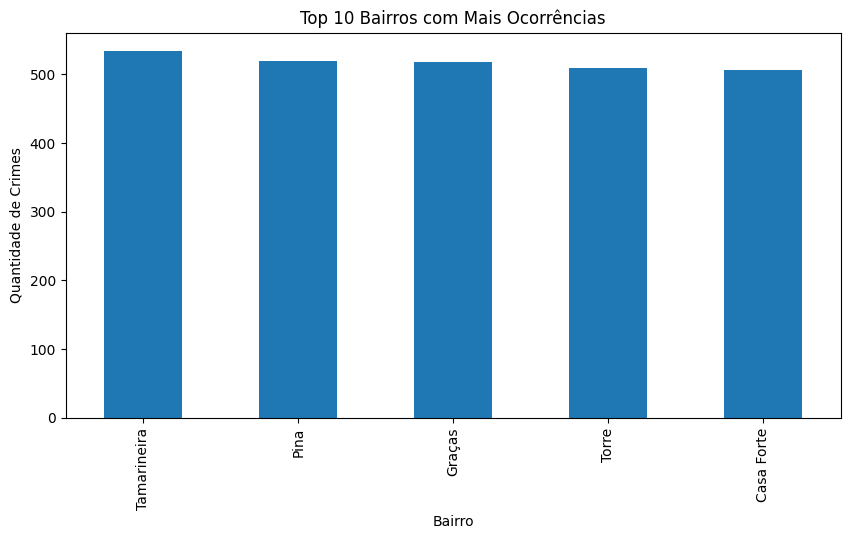

In [8]:
bairros = df['bairro'].value_counts().head(5)
plt.figure(figsize=(10,5))
bairros.plot(kind='bar')
plt.title("Top 10 Bairros com Mais Ocorrências")
plt.xlabel("Bairro")
plt.ylabel("Quantidade de Crimes")
plt.show()

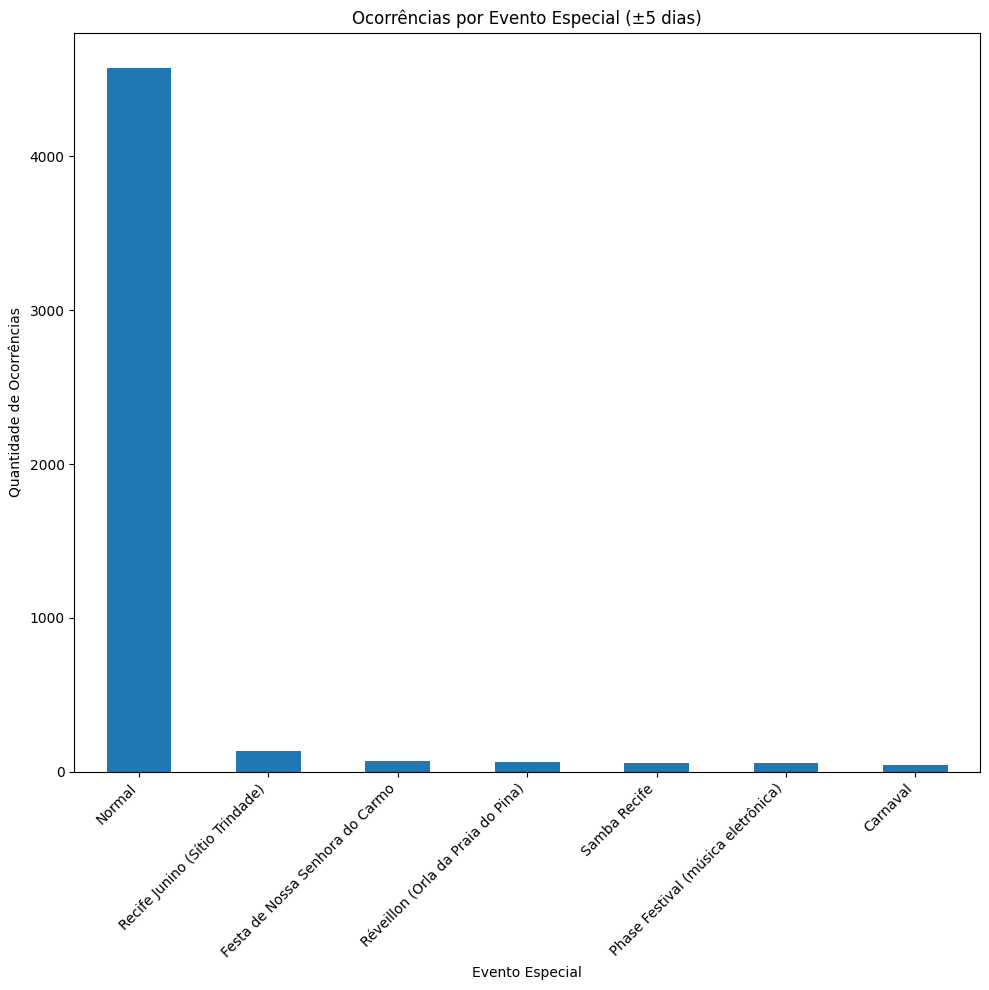

In [9]:
eventos = [
    {"nome": "Carnaval", "data": "20-02-2024"},
    {"nome": "Recife Junino (Sítio Trindade)", "data": "11-06-2024 a 30-06-2024"},
    {"nome": "Festival de Quadrilhas Juninas do Nordeste", "data": "22-06-2024"},
    {"nome": "Festa de Nossa Senhora do Carmo", "data": "06-07-2024 a 16-07-2024"},
    {"nome": "Samba Recife", "data": "28-09-2024 a 29-09-2024"},
    {"nome": "Phase Festival (música eletrônica)", "data": "09-11-2024"},
    {"nome": "Réveillon (Orla da Praia do Pina)", "data": "29-12-2024 a 31-12-2024"}
]

def processar_eventos(eventos, margem=5):
    eventos_processados = []
    for ev in eventos:
        if " a " in ev["data"]:
            inicio_str, fim_str = ev["data"].split(" a ")
            inicio = datetime.strptime(inicio_str, "%d-%m-%Y").date()
            fim = datetime.strptime(fim_str, "%d-%m-%Y").date()
        else:
            data = datetime.strptime(ev["data"], "%d-%m-%Y").date()
            inicio, fim = data, data
        inicio -= timedelta(days=margem)
        fim += timedelta(days=margem)

        eventos_processados.append({"nome": ev["nome"], "inicio": inicio, "fim": fim})
    return eventos_processados

eventos_proc = processar_eventos(eventos, margem=5)

df["evento_especial"] = "Normal"

# Preenche coluna com base nos eventos
for idx, row in df.iterrows():
    data = row["data_ocorrencia"].date()

    for ev in eventos_proc:
        if ev["inicio"] <= data <= ev["fim"]:
            df.loc[idx, "evento_especial"] = ev["nome"]
            break

# Contagem por evento
contagem = df["evento_especial"].value_counts()

# Gráfico
plt.figure(figsize=(10,10))
contagem.plot(kind="bar")

plt.title("Ocorrências por Evento Especial (±5 dias)")
plt.xlabel("Evento Especial")
plt.ylabel("Quantidade de Ocorrências")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

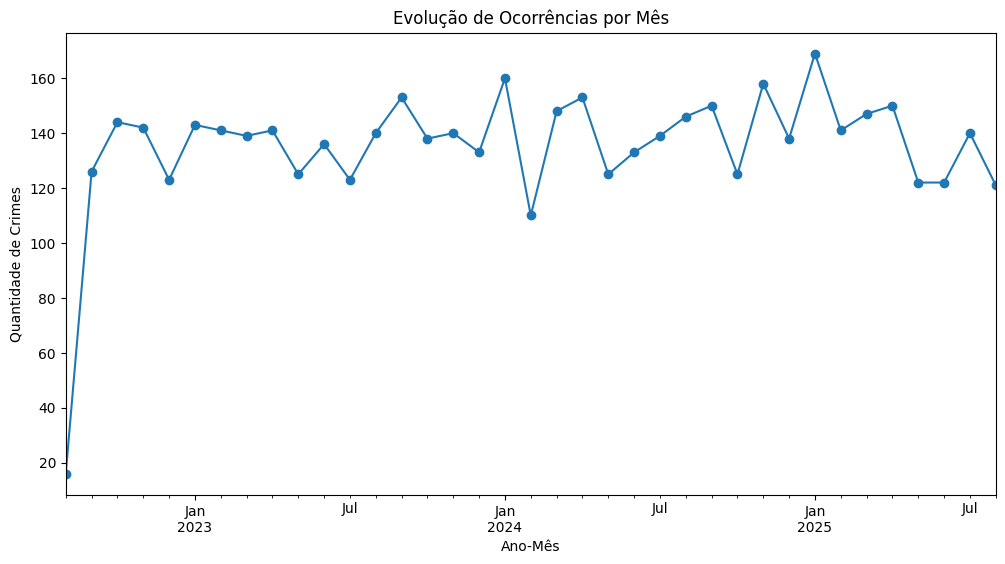

In [10]:
df['ano_mes'] = df['data_ocorrencia'].dt.to_period("M")
df.groupby('ano_mes').size().plot(kind="line", figsize=(12,6), marker='o')
plt.title("Evolução de Ocorrências por Mês")
plt.ylabel("Quantidade de Crimes")
plt.xlabel("Ano-Mês")
plt.show()

In [13]:
import streamlit as st
import pandas as pd
import plotly.express as px
from datetime import datetime, timedelta

# -----------------------
# Processamento dos eventos
# -----------------------
eventos = [
    {"nome": "Carnaval", "data": "20-02-2024"},
    {"nome": "Recife Junino (Sítio Trindade)", "data": "11-06-2024 a 30-06-2024"},
    {"nome": "Festival de Quadrilhas Juninas do Nordeste", "data": "22-06-2024"},
    {"nome": "Festa de Nossa Senhora do Carmo", "data": "06-07-2024 a 16-07-2024"},
    {"nome": "Samba Recife", "data": "28-09-2024 a 29-09-2024"},
    {"nome": "Phase Festival (música eletrônica)", "data": "09-11-2024"},
    {"nome": "Réveillon (Orla da Praia do Pina)", "data": "29-12-2024 a 31-12-2024"}
]

def processar_eventos(eventos, margem=5):
    eventos_processados = []
    for ev in eventos:
        if " a " in ev["data"]:
            inicio_str, fim_str = ev["data"].split(" a ")
            inicio = datetime.strptime(inicio_str, "%d-%m-%Y").date()
            fim = datetime.strptime(fim_str, "%d-%m-%Y").date()
        else:
            data = datetime.strptime(ev["data"], "%d-%m-%Y").date()
            inicio, fim = data, data
        inicio -= timedelta(days=margem)
        fim += timedelta(days=margem)
        eventos_processados.append({"nome": ev["nome"], "inicio": inicio, "fim": fim})
    return eventos_processados

# -----------------------
# Carregando dados
# -----------------------
# Substitua pelo seu CSV ou DataFrame
# Exemplo fictício:
# df = pd.read_csv("seuarquivo.csv", parse_dates=["data_ocorrencia"])

# Para testes (remova depois):
data_teste = {
    "data_ocorrencia": pd.date_range("2024-01-01", periods=200, freq="D"),
    "bairro": ["Boa Viagem", "Casa Forte", "Centro", "Afogados", "Ibura"] * 40
}
df = pd.DataFrame(data_teste)

# -----------------------
# Marcar eventos especiais
# -----------------------
eventos_proc = processar_eventos(eventos, margem=5)
df["evento_especial"] = "Normal"

for idx, row in df.iterrows():
    data = row["data_ocorrencia"].date()
    for ev in eventos_proc:
        if ev["inicio"] <= data <= ev["fim"]:
            df.loc[idx, "evento_especial"] = ev["nome"]
            break

df["ano_mes"] = df["data_ocorrencia"].dt.to_period("M").astype(str)

# -----------------------
# STREAMLIT DASHBOARD
# -----------------------
st.set_page_config(page_title="Dashboard de Ocorrências", layout="wide")

st.title("📊 Dashboard Interativo de Ocorrências Criminais")

# Filtro por período
min_date = df["data_ocorrencia"].min()
max_date = df["data_ocorrencia"].max()

data_range = st.slider(
    "Selecione o período:",
    min_value=min_date.to_pydatetime(),
    max_value=max_date.to_pydatetime(),
    value=(min_date.to_pydatetime(), max_date.to_pydatetime())
)

df_filtrado = df[(df["data_ocorrencia"] >= data_range[0]) & (df["data_ocorrencia"] <= data_range[1])]

# -----------------------
# Gráficos
# -----------------------
col1, col2 = st.columns(2)

# Top 10 bairros
bairros = df_filtrado['bairro'].value_counts().head(10).reset_index()
bairros.columns = ["bairro", "quantidade"]
fig_bairros = px.bar(
    bairros,
    x="bairro",
    y="quantidade",
    title="Top 10 Bairros com Mais Ocorrências",
    labels={"bairro": "Bairro", "quantidade": "Quantidade"}
)
col1.plotly_chart(fig_bairros, use_container_width=True)

# Ocorrências por evento especial
contagem_evento = df_filtrado["evento_especial"].value_counts().reset_index()
contagem_evento.columns = ["evento", "quantidade"]
fig_eventos = px.bar(
    contagem_evento,
    x="evento",
    y="quantidade",
    title="Ocorrências por Evento Especial (±5 dias)",
    labels={"evento": "Evento", "quantidade": "Quantidade"}
)
col2.plotly_chart(fig_eventos, use_container_width=True)

# Evolução mensal
ocorrencias_mes = df_filtrado.groupby("ano_mes").size().reset_index(name="quantidade")
fig_tempo = px.line(
    ocorrencias_mes,
    x="ano_mes",
    y="quantidade",
    markers=True,
    title="Evolução de Ocorrências por Mês"
)
st.plotly_chart(fig_tempo, use_container_width=True)

# -----------------------
# Tabela interativa
# -----------------------
st.subheader("📑 Dados filtrados")
st.dataframe(df_filtrado)


2025-09-09 21:19:31.358 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-09 21:19:31.361 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-09 21:19:31.362 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-09 21:19:31.363 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-09 21:19:31.364 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-09 21:19:31.365 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-09 21:19:31.366 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-09 21:19:31.368 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()